#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e30*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.31339593, -0.07414403, -0.94672364],
       [ 0.20875563,  0.9779392 , -0.0074839 ],
       [ 0.92639305, -0.19528846,  0.32196015]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.004531


In [26]:
Ret

array([[[ 0.31339593, -0.07414403, -0.94672364],
        [ 0.20875563,  0.9779392 , -0.0074839 ],
        [ 0.92639305, -0.19528846,  0.32196015]],

       [[ 0.66017735, -0.24205685,  0.71103751],
        [ 0.72913763,  0.43382331, -0.52929732],
        [-0.18034461,  0.86787431,  0.46289308]],

       [[ 0.70641432,  0.19999942,  0.67895438],
        [-0.60083714,  0.6764861 ,  0.42586533],
        [-0.37413038, -0.70877837,  0.59804655]],

       [[ 0.21808019, -0.55034246,  0.80595546],
        [ 0.39098116,  0.80593121,  0.44453191],
        [-0.89418945,  0.2181698 ,  0.39093116]],

       [[ 0.90704651,  0.34574396, -0.24026598],
        [-0.41545695,  0.82753917, -0.37759031],
        [ 0.06827995,  0.44231215,  0.89425825]],

       [[ 0.29554418, -0.88938399,  0.34878326],
        [ 0.95320342,  0.29887233, -0.04559125],
        [-0.06369354,  0.34593562,  0.93609384]],

       [[ 0.73913732,  0.48188081,  0.4706027 ],
        [ 0.6725208 , -0.4892901 , -0.55525757],
        

In [27]:
Ret.shape

(40, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))
    return ans.T

In [30]:
dx**2

array([6.16040421e-01, 2.78030425e-01, 1.94706919e-01, 6.02668938e-03,
       1.62296814e+00, 6.11274268e-01, 1.44244244e+00, 7.54427690e-04,
       7.45004315e-01, 2.16443617e+00, 2.59408293e+00, 3.73917910e-01,
       4.47317064e-01, 1.80391388e-01, 2.58748625e-02, 9.78760075e-01,
       7.10381879e-02, 3.73232658e-07, 7.71492910e-02, 8.06749468e-02,
       2.25772604e-01, 1.35835321e+00, 3.50194858e-06, 6.32392982e-02,
       5.77960050e-01, 4.12430548e-01, 3.82999489e-01, 3.15529226e-02,
       1.20738945e+00, 8.41877780e-01, 4.50339516e-02, 2.48916700e+00,
       2.51353718e-01, 1.15624736e-04, 1.11459817e+00, 1.31421799e-01,
       2.71686194e-01, 1.25988634e-02, 1.21928950e+00, 8.93039452e-01])

In [31]:
C1(dx,dy,dz,Ret)

array([[-2.01400979e+00,  5.09374475e-01, -2.02407939e-01,
         6.36640121e-01,  9.30920664e-01, -2.79167526e-01,
         2.21084499e+00,  2.19538756e-01, -2.66217868e+00,
        -1.92188053e+00, -6.55504336e+00, -1.40549865e+00,
         2.42547234e+00,  1.43943511e+00,  3.42977989e-01,
        -3.41256280e-01, -1.94749725e+00,  3.34063092e+00,
         5.25844766e-03,  4.64134235e+00,  5.14056677e+00,
         1.34256054e+00,  4.32610618e-03,  9.02712964e-02,
         2.50121173e-03,  4.16147543e-01, -7.83786576e-01,
        -1.36696607e-01, -3.73032601e+00,  1.75282932e+00,
         3.72444618e-01,  7.02889728e-01, -1.96188986e-01,
        -3.11856441e-02,  3.80659682e+00, -2.34639673e-02,
        -3.43198266e+00, -2.96782877e-01,  1.28596701e+00,
        -3.14071981e-01],
       [-1.90747517e+00,  1.59410893e-01, -4.67197165e-01,
        -2.56385832e-01, -2.01340343e+00,  7.30270946e-01,
        -3.60674356e-01,  2.36136533e-01, -6.16250512e-01,
        -2.48709818e+00, -1.38

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 40)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000210


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([-11558.47054882, -10947.06471269,  10193.42264844])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[-1.15584705e+04,  2.92331740e+03, -1.16162603e+03,
         3.65369926e+03,  5.34258528e+03, -1.60215191e+03,
         1.26881144e+04,  1.25994037e+03, -1.52783338e+04,
        -1.10297376e+04, -3.76196163e+04, -8.06620443e+03,
         1.39198681e+04,  8.26096694e+03,  1.96836232e+03,
        -1.95848137e+03, -1.11767528e+04,  1.91719942e+04,
         3.01784096e+01,  2.66368212e+04,  2.95018871e+04,
         7.70500052e+03,  2.48276702e+01,  5.18070034e+02,
         1.43545390e+01,  2.38828487e+03, -4.49817776e+03,
        -7.84506467e+02, -2.14084675e+04,  1.00595470e+04,
         2.13747230e+03,  4.03390800e+03, -1.12593525e+03,
        -1.78975470e+02,  2.18461884e+04, -1.34660505e+02,
        -1.96962650e+04, -1.70324700e+03,  7.38020834e+03,
        -1.80246976e+03],
       [-1.09470647e+04,  9.14864526e+02, -2.68126039e+03,
        -1.47140699e+03, -1.15549906e+04,  4.19104974e+03,
        -2.06992237e+03,  1.35519558e+03, -3.53668260e+03,
        -1.42735408e+04, -7.96

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.15584705e+04, -1.09470647e+04,  1.01934226e+04],
       [ 2.92331740e+03,  9.14864526e+02,  5.55239245e+03],
       [-1.16162603e+03, -2.68126039e+03, -8.74075065e+02],
       [ 3.65369926e+03, -1.47140699e+03,  2.09038086e+02],
       [ 5.34258528e+03, -1.15549906e+04, -4.86681102e+03],
       [-1.60215191e+03,  4.19104974e+03,  2.08697325e+02],
       [ 1.26881144e+04, -2.06992237e+03, -7.82789012e+03],
       [ 1.25994037e+03,  1.35519558e+03,  4.95293065e+03],
       [-1.52783338e+04, -3.53668260e+03, -1.64073732e+04],
       [-1.10297376e+04, -1.42735408e+04,  1.74234218e+04],
       [-3.76196163e+04, -7.96884177e+03,  1.64096689e+03],
       [-8.06620443e+03,  1.40923647e+04, -3.92975210e+03],
       [ 1.39198681e+04, -1.20989779e+04, -1.67718770e+04],
       [ 8.26096694e+03, -4.16899585e+03, -1.62425949e+03],
       [ 1.96836232e+03, -7.73655091e+02,  2.63307490e+03],
       [-1.95848137e+03, -5.23043139e+03, -6.55075790e+02],
       [-1.11767528e+04, -1.20290243e+04

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000616


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000234


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000143


In [61]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [62]:
phi(x,y,z,Ret,None)

array([[ -21.13895906,  -95.66563194,  -18.8138265 ],
       [-139.78094724,  -43.53944041,  -51.31583053],
       [ -20.93659836,  -64.30943471,  169.09522581],
       [-111.67750798,  167.00597661,  148.65115756],
       [ -73.09626505,  -92.58146894,   67.80103472],
       [-125.28918252,  -38.53142244,  -42.76377177],
       [ 121.38701274,  127.22815712,  -39.29007139],
       [ 190.25101744,  -84.28427986,  -55.46804558],
       [ -94.04040679,   63.04896091,   14.72725326],
       [  31.41521604,   50.17188804, -126.18707012],
       [ 111.22162966,   97.20893584,  -86.31460388],
       [   1.95984322, -150.34705643,   99.04725759],
       [  -2.62193044,   44.94818892,   37.70286489],
       [ -11.17549786,   85.49292497,  116.65556792],
       [ -77.856121  ,   -1.42525893,   18.00717921],
       [-163.17374371,  -41.15697645,  168.78039741],
       [-128.57683523,  -13.40874328,  151.6471778 ],
       [ -67.068289  ,    1.77616621,   24.62393601],
       [-121.31819748,   95.

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000253


In [65]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [66]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [67]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002309


In [68]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [69]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.001503


In [70]:
ωe(φ,θ,ψ,None,None)

array([[-2.12390555e-01, -1.24830383e+00,  9.67974000e-02],
       [ 7.63745940e-01,  5.26431759e-01, -4.43287936e-01],
       [-6.06897179e-01,  5.86300932e-01,  2.55134453e-01],
       [ 1.32371926e-01,  1.83353310e+00,  1.15121535e+00],
       [ 4.68433550e-01, -1.00981768e-01, -2.29672134e-01],
       [ 4.81063145e-01,  2.95466206e-01,  1.15311946e+00],
       [ 2.38270395e+00,  8.53547210e-01, -7.61951102e-01],
       [-1.03035446e+00, -7.59849115e-02, -2.50114266e-01],
       [-7.38034596e-01,  8.44192668e-01, -8.52462870e-01],
       [ 1.68783832e+00, -4.19957788e-01,  3.62971458e-01],
       [ 6.59834793e-01, -2.39375965e+00, -5.93005558e-01],
       [-8.72093482e-02,  1.09943777e+00,  8.40560795e-01],
       [-7.69912809e-01, -1.32727034e+00, -1.35604057e+00],
       [-9.84177575e-01, -1.22815302e+00, -1.29917708e+00],
       [ 1.81883038e+00,  4.13261559e-01,  4.14314418e-01],
       [-2.85282099e-01,  3.04945045e+00,  1.22324898e+00],
       [ 1.91115437e-02,  9.20531492e-02

In [71]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [72]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[  32.74555522,  -46.31479129,  115.54824304,   80.29696134,
         -28.11005119,   31.7960828 ,   63.40570522,  -16.86596608,
          66.17953779,   34.78228121,  264.2618617 ,  235.27214048,
          10.90967227,  -32.20043961,    8.03218027,  565.03268011,
           3.47143235,   25.0657272 ,    8.36859177,  -23.28254042,
          55.38675421,  -33.26315137,  203.17323404,  -71.76441629,
        -155.39566202,  435.66293506, -444.38559737,  -17.41698267,
          92.74069864,   50.64239982,    3.77921978,   28.7782304 ,
         456.82685666,   10.44498691,   43.89434579,   25.23646273,
        -102.46611605, -148.55055868,    8.57791659,    8.9618289 ],
       [  -6.04207521,  101.15546347,   97.28177077, -148.24209827,
         -14.97210282, -123.90132222,    1.12563307, -104.73624167,
          91.035176  ,  224.38620369,   -9.00166257,   10.2852141 ,
          32.58336309,  129.32874774,  -65.00891666, -151.45208186,
          97.67313171,   49.8712028 ,   49.2598

In [73]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [74]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [75]:
# d_s(phi,x,y,z,Ret)

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001585


In [77]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [78]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [79]:
# sigma(x,y,z)

In [80]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.15584705e+04, -2.92331740e+03,  1.16162603e+03,
        -3.65369926e+03, -5.34258528e+03,  1.60215191e+03,
        -1.26881144e+04, -1.25994037e+03,  1.52783338e+04,
         1.10297376e+04,  3.76196163e+04,  8.06620443e+03,
        -1.39198681e+04, -8.26096694e+03, -1.96836232e+03,
         1.95848137e+03,  1.11767528e+04, -1.91719942e+04,
        -3.01784096e+01, -2.66368212e+04, -2.95018871e+04,
        -7.70500052e+03, -2.48276702e+01, -5.18070034e+02,
        -1.43545390e+01, -2.38828487e+03,  4.49817776e+03,
         7.84506467e+02,  2.14084675e+04, -1.00595470e+04,
        -2.13747230e+03, -4.03390800e+03,  1.12593525e+03,
         1.78975470e+02, -2.18461884e+04,  1.34660505e+02,
         1.96962650e+04,  1.70324700e+03, -7.38020834e+03,
         1.80246976e+03],
       [ 1.09470647e+04, -9.14864526e+02,  2.68126039e+03,
         1.47140699e+03,  1.15549906e+04, -4.19104974e+03,
         2.06992237e+03, -1.35519558e+03,  3.53668260e+03,
         1.42735408e+04,  7.96

In [81]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [82]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.002923


In [83]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 3.18538965e+09, -5.97807618e+09, -7.25168895e+08],
       [-2.04732952e+10,  1.89005029e+10,  8.68059249e+09],
       [ 5.73085053e+10,  4.47943546e+10,  1.84833124e+10],
       [ 3.80846895e+09, -9.65409188e+10,  3.48087557e+10],
       [-2.38733347e+10, -9.96869759e+09, -4.06389907e+10],
       [ 2.75145764e+09, -1.11525896e+10,  1.62516559e+10],
       [ 3.42362481e+10,  1.08477248e+08,  9.38444792e+10],
       [-3.54305672e+09, -1.67218160e+08,  1.94820954e+10],
       [ 6.21771293e+09,  2.01588279e+10,  1.70090566e+10],
       [ 2.90064398e+09,  1.52839256e+11,  1.96655671e+10],
       [ 4.67122458e+10, -7.38937995e+09,  3.26219312e+10],
       [ 7.88732446e+10,  7.37470791e+09,  4.71601281e+09],
       [ 9.79211974e+07,  9.26602814e+09, -1.05857569e+10],
       [-1.06277588e+10,  4.03610658e+09, -1.20792839e+08],
       [ 4.98619602e+09, -6.21542242e+09,  2.37839523e+09],
       [ 5.21817025e+10, -1.53152039e+10,  4.91640099e+11],
       [ 1.38847021e+09,  4.96661476e+10

In [84]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000297


In [85]:
Re_b(Ret).shape

(40, 3, 3)

In [86]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [87]:
Irho_e(Ret)

array([[[9.82170114e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.56365079e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.07316679e+01]],

       [[4.35834140e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88202667e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.28540012e+01]],

       [[4.99021186e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.57633450e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.15319344e+01]],

       [[4.75589697e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.49525120e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.05654348e+01]],

       [[8.22733374e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.84821082e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.59939563e+02]],

       [[8.73463643e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.93246688e+00, 0.00000000e+00],
    

In [88]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000229


In [89]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [90]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [91]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [92]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [93]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [94]:
# ωe(φ,θ,ψ,None)

In [95]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [96]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [97]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [98]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.002162


In [99]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [100]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [101]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [102]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.15584705e+04, -2.92331740e+03,  1.16162603e+03,
        -3.65369926e+03, -5.34258528e+03,  1.60215191e+03,
        -1.26881144e+04, -1.25994037e+03,  1.52783338e+04,
         1.10297376e+04,  3.76196163e+04,  8.06620443e+03,
        -1.39198681e+04, -8.26096694e+03, -1.96836232e+03,
         1.95848137e+03,  1.11767528e+04, -1.91719942e+04,
        -3.01784096e+01, -2.66368212e+04, -2.95018871e+04,
        -7.70500052e+03, -2.48276702e+01, -5.18070034e+02,
        -1.43545390e+01, -2.38828487e+03,  4.49817776e+03,
         7.84506467e+02,  2.14084675e+04, -1.00595470e+04,
        -2.13747230e+03, -4.03390800e+03,  1.12593525e+03,
         1.78975470e+02, -2.18461884e+04,  1.34660505e+02,
         1.96962650e+04,  1.70324700e+03, -7.38020834e+03,
         1.80246976e+03],
       [ 1.09470647e+04, -9.14864526e+02,  2.68126039e+03,
         1.47140699e+03,  1.15549906e+04, -4.19104974e+03,
         2.06992237e+03, -1.35519558e+03,  3.53668260e+03,
         1.42735408e+04,  7.96

In [103]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [104]:
Re_b(Ret).shape

(40, 3, 3)

In [105]:
ne_(dx,dy,dz,DT, Ret).T

array([[ 1.15584705e+04,  1.09470647e+04, -1.03215872e+04],
       [-2.92331740e+03, -9.14864526e+02, -5.68055700e+03],
       [ 1.16162603e+03,  2.68126039e+03,  7.45910523e+02],
       [-3.65369926e+03,  1.47140699e+03, -3.37202629e+02],
       [-5.34258528e+03,  1.15549906e+04,  4.73864648e+03],
       [ 1.60215191e+03, -4.19104974e+03, -3.36861867e+02],
       [-1.26881144e+04,  2.06992237e+03,  7.69972557e+03],
       [-1.25994037e+03, -1.35519558e+03, -5.08109519e+03],
       [ 1.52783338e+04,  3.53668260e+03,  1.62792087e+04],
       [ 1.10297376e+04,  1.42735408e+04, -1.75515864e+04],
       [ 3.76196163e+04,  7.96884177e+03, -1.76913144e+03],
       [ 8.06620443e+03, -1.40923647e+04,  3.80158756e+03],
       [-1.39198681e+04,  1.20989779e+04,  1.66437125e+04],
       [-8.26096694e+03,  4.16899585e+03,  1.49609495e+03],
       [-1.96836232e+03,  7.73655091e+02, -2.76123944e+03],
       [ 1.95848137e+03,  5.23043139e+03,  5.26911248e+02],
       [ 1.11767528e+04,  1.20290243e+04

In [106]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ -88.31372193,  -29.58918079, -167.54278305,  228.48739082,
         -71.89816493,   85.12070097,  -32.31742455,  -55.64169628,
         -40.25731007,  -85.23098493,   98.65572085, -138.05822752,
         -47.23370634,  -99.80276311,  -27.2793202 ,  115.11538483,
         -99.02147037,   22.1495013 ,   13.88389834, -121.02707301,
         100.78278164, -113.62916233,   59.31962441,   68.6582799 ,
         100.92229728, -212.98287198,   32.93243955,  -24.96515603,
         111.41123804,   98.30612798,  -48.45444885,  -49.26939791,
          -3.73635614,  -49.92597892,   -5.87895435,   84.70338573,
          49.40382255,  147.33684328,  118.23741125,  -11.37231307]),
 array([  14.67140173, -100.09793208,   59.52466038,   42.34475539,
         113.1520459 ,  -81.97297585,   13.42293901, -205.00430066,
         -57.92966522,  -50.99446023, -104.78150477,   -1.63305755,
         -33.23481558,   55.69072056,    6.90340323, -197.07173649,
         145.8330646 ,  -49.77

In [107]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[ 2.41408792e+04,  2.41427697e+04, -5.07487541e+03],
       [-8.67086533e+03, -4.36551129e+02, -8.57683046e+03],
       [ 3.02490500e+03,  4.11480526e+03, -1.14301929e+03],
       [-5.53204673e+03,  1.07883493e+03,  3.11909020e+03],
       [-7.33202631e+03,  2.15475449e+04,  1.37223413e+04],
       [ 5.68561937e+03, -3.90110397e+03, -2.20407634e+03],
       [-1.74454056e+04, -1.17512219e+04,  4.39779452e+03],
       [ 2.47552521e+03, -5.20760699e+03, -5.74949375e+03],
       [ 3.36095230e+04, -9.04413055e+03,  2.03582897e+04],
       [-1.36808965e+04,  1.37984446e+04, -1.27969996e+04],
       [ 2.17428005e+04,  2.66693986e+04,  2.78970742e+04],
       [ 2.23122220e+04, -2.23484520e+04,  1.15612706e+03],
       [-2.06252131e+04, -1.07969804e+04,  9.71734204e+03],
       [-1.34448925e+04, -6.84083144e+02, -4.62247846e+03],
       [-2.81432786e+03,  3.07090324e+03, -2.90525129e+02],
       [-3.44263934e+03,  5.08180051e+03, -9.81895741e+02],
       [ 2.74898684e+04,  1.28248905e+04

In [108]:
ne_(dx,dy,dz,DT,Ret).T

array([[ 1.15584705e+04,  1.09470647e+04, -1.03215872e+04],
       [-2.92331740e+03, -9.14864526e+02, -5.68055700e+03],
       [ 1.16162603e+03,  2.68126039e+03,  7.45910523e+02],
       [-3.65369926e+03,  1.47140699e+03, -3.37202629e+02],
       [-5.34258528e+03,  1.15549906e+04,  4.73864648e+03],
       [ 1.60215191e+03, -4.19104974e+03, -3.36861867e+02],
       [-1.26881144e+04,  2.06992237e+03,  7.69972557e+03],
       [-1.25994037e+03, -1.35519558e+03, -5.08109519e+03],
       [ 1.52783338e+04,  3.53668260e+03,  1.62792087e+04],
       [ 1.10297376e+04,  1.42735408e+04, -1.75515864e+04],
       [ 3.76196163e+04,  7.96884177e+03, -1.76913144e+03],
       [ 8.06620443e+03, -1.40923647e+04,  3.80158756e+03],
       [-1.39198681e+04,  1.20989779e+04,  1.66437125e+04],
       [-8.26096694e+03,  4.16899585e+03,  1.49609495e+03],
       [-1.96836232e+03,  7.73655091e+02, -2.76123944e+03],
       [ 1.95848137e+03,  5.23043139e+03,  5.26911248e+02],
       [ 1.11767528e+04,  1.20290243e+04

### Vessel

In [109]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [110]:
V=VesselSemisub()

In [111]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [112]:
tau_force = V.tau(η,dη, ddη)

In [113]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [114]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [115]:
V=VesselOtter()

In [116]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [117]:
tau_force = V.tau(η,dη, ddη)

In [118]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [119]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [120]:
V=VesselSemisub()

In [121]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [122]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [123]:
Hs = 2.5 # significant wave height in m

In [124]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [125]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [126]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [127]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [128]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[5828.76914536 7132.08869406    0.            0.            0.
    0.        ]


### Static solution

In [129]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [130]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [131]:
Fx_0=82945396

In [132]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [133]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [134]:
delta_x=horizontal_length/(node_N-1)

In [135]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [136]:
x0,z0

([0.0,
  283.4021754990159,
  566.8043509980319,
  850.2065264970478,
  1133.6087019960637,
  1417.0108774950795,
  1700.4130529940956,
  1983.8152284931116,
  2267.2174039921274,
  2550.619579491143,
  2834.021754990159,
  3117.4239304891753,
  3400.826105988191,
  3684.228281487207,
  3967.630456986223,
  4251.0326324852385,
  4534.434807984255,
  4817.836983483271,
  5101.239158982286,
  5384.641334481303,
  5668.043509980318,
  5951.445685479334,
  6234.847860978351,
  6518.250036477366,
  6801.652211976382,
  7085.0543874753985,
  7368.456562974414,
  7651.85873847343,
  7935.260913972446,
  8218.663089471462,
  8502.065264970477,
  8785.467440469494,
  9068.86961596851,
  9352.271791467525,
  9635.673966966542,
  9919.076142465557,
  10202.478317964573,
  10485.88049346359,
  10769.282668962605,
  11052.68484446162],
 [0.0,
  0.45595784671552586,
  1.8238361078331267,
  4.103648946148533,
  7.295419966536416,
  11.399182216224183,
  16.414978184967982,
  22.34285980571763,
  29.1

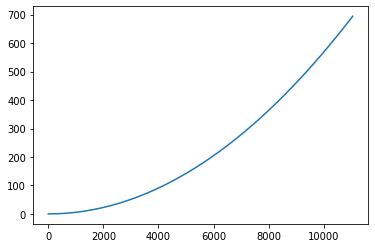

In [137]:
plt.plot(x0, z0)
plt.show()

In [138]:
# rng = np.random.default_rng(seed=29)
rng = np.random.default_rng(seed=30)
q0=np.zeros(12*node_N)

In [139]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [140]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [141]:
q0

array([0.00000000e+00, 2.83402175e+02, 5.66804351e+02, 8.50206526e+02,
       1.13360870e+03, 1.41701088e+03, 1.70041305e+03, 1.98381523e+03,
       2.26721740e+03, 2.55061958e+03, 2.83402175e+03, 3.11742393e+03,
       3.40082611e+03, 3.68422828e+03, 3.96763046e+03, 4.25103263e+03,
       4.53443481e+03, 4.81783698e+03, 5.10123916e+03, 5.38464133e+03,
       5.66804351e+03, 5.95144569e+03, 6.23484786e+03, 6.51825004e+03,
       6.80165221e+03, 7.08505439e+03, 7.36845656e+03, 7.65185874e+03,
       7.93526091e+03, 8.21866309e+03, 8.50206526e+03, 8.78546744e+03,
       9.06886962e+03, 9.35227179e+03, 9.63567397e+03, 9.91907614e+03,
       1.02024783e+04, 1.04858805e+04, 1.07692827e+04, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [142]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
root

array([ 2.04222156e+05,  2.10155343e+05, -4.13527296e+05,  8.50205337e+02,
        1.13360751e+03,  1.41700969e+03,  1.70041187e+03,  1.98381404e+03,
        2.26721622e+03,  2.55061839e+03,  2.83402057e+03,  3.11742274e+03,
        3.40082492e+03,  3.68422709e+03,  3.96762927e+03,  4.25103144e+03,
        4.53443362e+03,  4.81783579e+03,  5.10123797e+03,  5.38464014e+03,
        5.66804232e+03,  5.95144449e+03,  6.23484667e+03,  6.51824885e+03,
        6.80165102e+03,  7.08505320e+03,  7.36845537e+03,  7.65185755e+03,
        7.93525972e+03,  8.21866190e+03,  8.50206407e+03,  8.78546625e+03,
        9.06886842e+03,  9.35227060e+03,  9.63567277e+03,  9.91907495e+03,
        1.02024771e+04,  1.04858793e+04,  1.07692815e+04,  1.10526837e+04,
        2.64336809e-19,  2.64336809e-19,  2.64336809e-19,  2.64267964e-19,
        2.64191854e-19,  2.64150494e-19,  2.64145316e-19,  2.64158653e-19,
        2.64178115e-19,  2.64198298e-19,  2.64217330e-19,  2.64234752e-19,
        2.64250600e-19,  

In [144]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [145]:
x0

[0.0,
 283.4021754990159,
 566.8043509980319,
 850.2065264970478,
 1133.6087019960637,
 1417.0108774950795,
 1700.4130529940956,
 1983.8152284931116,
 2267.2174039921274,
 2550.619579491143,
 2834.021754990159,
 3117.4239304891753,
 3400.826105988191,
 3684.228281487207,
 3967.630456986223,
 4251.0326324852385,
 4534.434807984255,
 4817.836983483271,
 5101.239158982286,
 5384.641334481303,
 5668.043509980318,
 5951.445685479334,
 6234.847860978351,
 6518.250036477366,
 6801.652211976382,
 7085.0543874753985,
 7368.456562974414,
 7651.85873847343,
 7935.260913972446,
 8218.663089471462,
 8502.065264970477,
 8785.467440469494,
 9068.86961596851,
 9352.271791467525,
 9635.673966966542,
 9919.076142465557,
 10202.478317964573,
 10485.88049346359,
 10769.282668962605,
 11052.68484446162]

In [146]:
x0_

array([ 204222.15607982,  210155.343016  , -413527.29620752,
           850.20533701,    1133.60751359,    1417.00968967,
          1700.41186525,    1983.81404056,    2267.21621578,
          2550.61839099,    2834.02056622,    3117.42274147,
          3400.82491675,    3684.22709204,    3967.62926735,
          4251.03144267,    4534.43361801,    4817.83579335,
          5101.2379687 ,    5384.64014405,    5668.04231942,
          5951.44449478,    6234.84667015,    6518.24884552,
          6801.65102089,    7085.05319626,    7368.45537163,
          7651.857547  ,    7935.25972237,    8218.66189775,
          8502.06407312,    8785.46624849,    9068.86842386,
          9352.27059923,    9635.6727746 ,    9919.07494996,
         10202.47712533,   10485.87930069,   10769.28147605,
         11052.68365142])

In [147]:
z0

[0.0,
 0.45595784671552586,
 1.8238361078331267,
 4.103648946148533,
 7.295419966536416,
 11.399182216224183,
 16.414978184967982,
 22.34285980571763,
 29.18288845492951,
 36.93513495338796,
 45.599679566811496,
 55.176612006791565,
 65.6660314316139,
 77.06804644731459,
 89.38277510891209,
 102.61034492144378,
 116.7508928414327,
 131.80456527829557,
 147.77151809573138,
 164.65191661348138,
 182.44593560897198,
 201.15375931915287,
 220.77558144233552,
 241.31160514032476,
 262.76204304039396,
 285.12711723755365,
 308.40705929683963,
 332.60211025571834,
 357.71252062657067,
 383.73855039927344,
 410.6804690438979,
 438.53855551356554,
 467.3130982472245,
 497.00439517270087,
 527.6127537097688,
 559.1384907733774,
 591.5819327768386,
 624.943415635308,
 659.2232847691683,
 694.4218951076863]

In [148]:
z0_

array([-5.13321894e-07,  4.62203401e-01,  1.87740641e+00,  4.16539191e+00,
        7.68419502e+00,  1.21281877e+01,  1.71447933e+01,  2.28715131e+01,
        2.94881790e+01,  3.70770103e+01,  4.56378457e+01,  5.51502662e+01,
        6.55980278e+01,  7.69713229e+01,  8.92646403e+01,  1.02475004e+02,
        1.16600743e+02,  1.31640924e+02,  1.47595015e+02,  1.64462777e+02,
        1.82244009e+02,  2.00938657e+02,  2.20546712e+02,  2.41068184e+02,
        2.62503107e+02,  2.84851566e+02,  3.08113658e+02,  3.32289629e+02,
        3.57379889e+02,  3.83385217e+02,  4.10307120e+02,  4.38148789e+02,
        4.66916765e+02,  4.96625174e+02,  5.27305788e+02,  5.59035374e+02,
        5.92052984e+02,  6.72713096e+02,  6.59285114e+02,  6.94421895e+02])

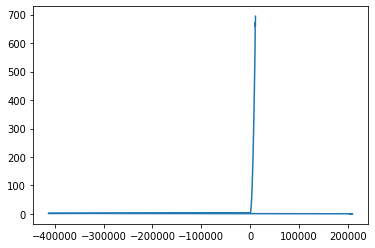

In [149]:
plt.plot(x0_, z0_)
plt.show()

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
# q0[10*node_N]=q0[8*node_N]=0

In [152]:
q0

array([ 2.04222156e+05,  2.10155343e+05, -4.13527296e+05,  8.50205337e+02,
        1.13360751e+03,  1.41700969e+03,  1.70041187e+03,  1.98381404e+03,
        2.26721622e+03,  2.55061839e+03,  2.83402057e+03,  3.11742274e+03,
        3.40082492e+03,  3.68422709e+03,  3.96762927e+03,  4.25103144e+03,
        4.53443362e+03,  4.81783579e+03,  5.10123797e+03,  5.38464014e+03,
        5.66804232e+03,  5.95144449e+03,  6.23484667e+03,  6.51824885e+03,
        6.80165102e+03,  7.08505320e+03,  7.36845537e+03,  7.65185755e+03,
        7.93525972e+03,  8.21866190e+03,  8.50206407e+03,  8.78546625e+03,
        9.06886842e+03,  9.35227060e+03,  9.63567277e+03,  9.91907495e+03,
        1.02024771e+04,  1.04858793e+04,  1.07692815e+04,  1.10526837e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Dynamics

In [157]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
# #     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
#     y[-1]+=5*np.cos(t)
#     z[-1]=z0[-1]+2.5*np.sin(t)
#     z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

    hack =1
    ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
                        - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                        , rcond=None)[0]
#     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        + Z0
       )

############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=np.linalg.lstsq(Ws*RRRR[i], Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= -np.dot(DR,K1).astype(np.float32).T
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [158]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [159]:
tspan = (0., 5)
# tspan = (0., 10)

In [160]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
2.248152926593457e-25
4.496305853186915e-24
6.74445877978037e-24
1.798522341274766e-23
1.9983581569719617e-23
2.248152926593457e-23
2.248152926593457e-23
6.744458779780371e-23
8.992611706373827e-23
2.0233376339341113e-22
2.223173449631307e-22
2.4729682192528024e-22
2.4729682192528024e-22
6.969274072439717e-22
9.217426999033172e-22
2.045819163200046e-21
2.245654978897242e-21
2.4954497485187373e-21
2.4954497485187373e-21
6.991755601705652e-21
9.239908528299109e-21
2.0480673161266392e-20
2.2479031318238352e-20
2.4976979014453307e-20
2.4976979014453307e-20
6.994003754632245e-20
9.242156681225701e-20
2.0482921314192988e-19
2.2481279471164944e-19
2.49792271673799e-19
2.49792271673799e-19
6.994228569924904e-19
9.24238149651836e-19
2.0483146129485643e-18
2.24815042864576e-18
2.4979451982672555e-18
2.4979451982672555e-18
6.99425105145417e-18
9.242403978047626e-18
2.0483168611014913e-17
2.248152676798687e-17
2.4979474464201825e-17
2.4979474464201825e-17
6.994253299607096e-17
9.24240622620055

6.8570993760598805e-12
6.882052002996039e-12
6.894528316464119e-12
6.956909883804515e-12
6.967999940220586e-12
6.981862510740674e-12
6.981862510740674e-12
7.005528024813866e-12
7.017360781850462e-12
7.076524567033441e-12
7.087042573288194e-12
7.100190081106633e-12
7.100190081106633e-12
6.98838152713931e-12
6.991641035338627e-12
7.007938576335216e-12
7.0108359169568315e-12
7.0144575927338514e-12
7.0144575927338514e-12
7.020976609132487e-12
7.0242361173318044e-12
7.040533658328393e-12
7.043430998950009e-12
7.047052674727029e-12
7.047052674727029e-12
7.061775915890123e-12
7.06913753647167e-12
7.105945639379404e-12
7.1124893021185575e-12
7.120668880542498e-12
7.120668880542498e-12
7.136413941462723e-12
7.1442864719228365e-12
7.1836491242234e-12
7.1906469290768325e-12
7.199394185143625e-12
7.199394185143625e-12
7.2149348662054034e-12
7.222705206736293e-12
7.261556909390739e-12
7.2684638787515296e-12
7.277097590452518e-12
7.277097590452518e-12
7.212141931297473e-12
7.218515804374397e-12
7.25

9.240332140536717e-12
9.245284457201744e-12


KeyboardInterrupt: 

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()